In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
import matplotlib.pyplot as plt
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(history.epoch, np.array(history.history['mape']), 
           label='Train')
  plt.plot(history.epoch, np.array(history.history['val_mape']),
           label = 'Val')
  plt.legend()
  plt.ylim([0,max(history.history['val_mape'])])

def plot_prediction(test_labels, test_predictions):
  plt.figure()
  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  _ = plt.plot([-100, 100],[-100,100])

  plt.figure()
  error = test_predictions - test_labels
  plt.hist(error, bins = 50)
  plt.xlabel("Prediction Error")
  _ = plt.ylabel("Count")

In [3]:
df = pd.read_csv('data/export.csv')
df.head()

,drug_id,drug_name,synonyms,pathway_name,targets,pubchem
0,1259,Talazoparib,"BMN-673, BMN 973",Genome integrity,"PARP1, PARP2",44819241
1,1372,Trametinib,"GSK1120212, Mekinist",ERK MAPK signaling,"MEK1, MEK2",11707110
2,1559,Luminespib,"AUY922, VER-52296,NVP-AUY922, AUY",Protein stability and degradation,HSP90,10096043
3,1615,CZC24832,GTPL6653,PI3K/MTOR signaling,PI3Kgamma,42623951
4,1620,PFI3,"PFI-3, PFI 3, AOB2221",Chromatin other,"Polybromo 1, SMARCA4, SMARCA2",78243717


In [4]:
def readGeneticData(dataPath):
    df_Gen = pd.read_csv(dataPath)
    df_Gen['IS Mutated']=df_Gen['IS Mutated'].dropna()
    df_Gen['Recurrent Gain Loss']=df_Gen['Recurrent Gain Loss'].fillna('nan')
    df_Gen['Recurrent Gain Loss']=df_Gen['Recurrent Gain Loss'].map({'gain': 1, 'loss':0, 'nan': 3})
    return df_Gen
df_Gen = readGeneticData('data\PANCANCER_Genetic_features_Mon Feb 19 14_07_49 2024.csv')
df_Gen.head()

C:\Users\Nemo\AppData\Local\Temp\ipykernel_38320\14521728.py:2: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_Gen = pd.read_csv(dataPath)


,Cell Line Name,COSMIC ID,GDSC Desc1,GDSC Desc2,TCGA Desc,Genetic Feature,IS Mutated,Recurrent Gain Loss,Genes in Segment
0,CAL-29,1290730,urogenital_system,bladder,BLCA,CDC27_mut,0,3,NaN
1,CAL-29,1290730,urogenital_system,bladder,BLCA,CDC73_mut,0,3,NaN
2,CAL-29,1290730,urogenital_system,bladder,BLCA,CDH1_mut,0,3,NaN
3,CAL-29,1290730,urogenital_system,bladder,BLCA,CDK12_mut,0,3,NaN
4,CAL-29,1290730,urogenital_system,bladder,BLCA,CDKN1A_mut,0,3,NaN


In [5]:
def readICData(dataPath):
    df_IC = pd.read_csv(dataPath)
    return df_IC

df_IC = readICData("data\PANCANCER_IC_Mon Feb 19 14_07_21 2024.csv")

In [6]:
def load_merge_data( ):
    df_select2 = pd.read_csv("/results/N-acetyl cysteine/N-acetyl cysteine_noNAN.csv")
    
    df_select2['Tissue'] = df_select2['Tissue'].astype('category').cat.codes
    df_select2['Tissue Sub-type'] = df_select2['Tissue Sub-type'].astype('category').cat.codes
    df_input = df_select2.drop(['Drug Name','Cell Line Name','IC50'], axis=1)
    df_output = df_select2['IC50']
    return df_input, df_output

In [7]:
df_input, df_output = load_merge_data()    
X_train, X_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.05, random_state=42)

In [8]:
def build_model():
  model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),                  
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ], name="MLP_model")

  optimizer = tf.keras.optimizers.Adam(0.1)

  model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mape'])
  return model

model = build_model()
model.summary()

Model: "MLP_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        94,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,561 (385.00 KB)

 Trainable params: 98,561 (385.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
EPOCHS = 500
# Store training stats
history = model.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=1)

Epoch 1/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 29470.1660 - mape: 295252.5312 - val_loss: 7.8868 - val_mape: 78.8616
Epoch 2/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8928 - mape: 68.9546 - val_loss: 3.4955 - val_mape: 34.5972
Epoch 3/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2325 - mape: 22.2082 - val_loss: 1.2055 - val_mape: 12.5323
Epoch 4/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9871 - mape: 10.3441 - val_loss: 0.7499 - val_mape: 7.5866
Epoch 5/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6793 - mape: 6.8158 - val_loss: 0.7298 - val_mape: 7.3997
Epoch 6/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6541 - mape: 6.5279 - val_loss: 0.7323 - val_mape: 7.4440
Epoch 7/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6923 - mape: 6.9919 - val_loss: 0.7330 - val_mape: 7.4525
Epoch 8/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6622 - mape: 6.8290 - val_loss: 0.7254 - val_mape: 7.3620
Epoch 9/500
18/18 ━━━━━━━━━━━━━━━

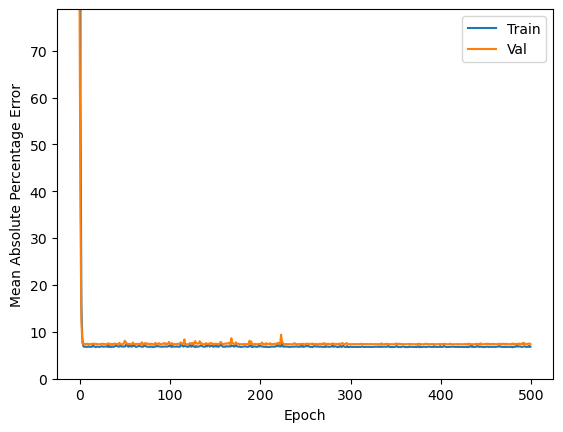

In [10]:
plot_history(history)

In [11]:
[loss, mae] = model.evaluate(X_test, y_test, verbose=0)
print("Testing set Mean Abs Error: {:7.2f}".format(mae))

Testing set Mean Abs Error:    6.28


# CNN

In [12]:
sample_size = X_train.shape[0] # number of samples in train set
time_steps  = X_train.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number

train_data_reshaped = X_train.values.reshape(sample_size,time_steps,input_dimension)
# print("After reshape train data set shape:\n", train_data_reshaped.shape)
# print("1 Sample shape:\n",train_data_reshaped[0].shape)
# print("An example sample:\n", train_data_reshaped[0])

In [13]:
test_data_reshaped = X_test.values.reshape(X_test.shape[0],X_test.shape[1],1)

In [18]:
def build_conv1D_model():

  n_timesteps = train_data_reshaped.shape[1] #13
  n_features  = train_data_reshaped.shape[2] #1 
  model = keras.Sequential(name="model_conv1D")
  model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
  model.add(keras.layers.Conv1D(filters=64, kernel_size=7, activation='relu', name="Conv1D_1"))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
  model.add(keras.layers.Dropout(0.1))
  model.add(keras.layers.Conv1D(filters=8, kernel_size=2, activation='relu', name="Conv1D_3"))
  
  model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(4, activation='relu', name="Dense_1"))
  model.add(keras.layers.Dense(n_features, name="Dense_2"))


  optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01,
    beta_1=0.05,
    beta_2=0.099,
    epsilon=1e-06,
    amsgrad=True,
    clipnorm=0.001,
    clipvalue=0.1,
    # global_clipnorm=None
                                       )#RMSprop

  model.compile(loss='mae',optimizer=optimizer,metrics=['mape'])
  return model

model_conv1D = build_conv1D_model()
model_conv1D.summary()

Model: "model_conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1D_1 (Conv1D)               │ (None, 1467, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1467, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_2 (Conv1D)               │ (None, 1465, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1465, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_3 (Conv1D)               │ (None, 1464, 8)        │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1D (MaxPooling1D)     │ (None, 732, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5856)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 4)              │        23,428 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,641 (119.69 KB)

 Trainable params: 30,641 (119.69 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Store training stats
history = model_conv1D.fit(train_data_reshaped, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=1)

Epoch 1/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 30.9972 - mape: 316.6433 - val_loss: 9.8241 - val_mape: 98.3893
Epoch 2/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.8929 - mape: 98.8230 - val_loss: 9.6443 - val_mape: 96.5767
Epoch 3/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.5563 - mape: 96.1113 - val_loss: 9.4644 - val_mape: 94.7642
Epoch 4/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.3688 - mape: 94.2838 - val_loss: 9.2846 - val_mape: 92.9516
Epoch 5/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.2126 - mape: 92.4554 - val_loss: 9.1048 - val_mape: 91.1390
Epoch 6/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.0363 - mape: 90.4392 - val_loss: 8.9250 - val_mape: 89.3264
Epoch 7/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.8951 - mape: 88.7972 - val_loss: 8.7452 - val_mape: 87.5139
Epoch 8/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7150 - mape: 87.1257 - val_loss: 8.5653 - val_mape: 85.7013
Epoch 9/500
18/18 ━━━━

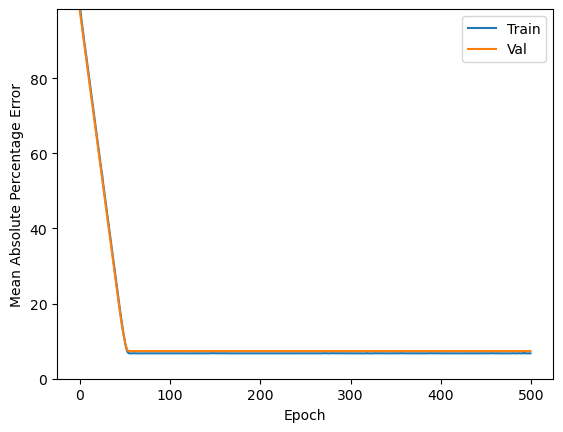

In [20]:
plot_history(history)

In [21]:
[loss, mae] = model_conv1D.evaluate(test_data_reshaped, y_test, verbose=0)
print("Testing set Mean Abs Error: {:7.2f}".format(mae))

Testing set Mean Abs Error:    6.12
